# Consistency of common DEGs
How consistent are common DEGs across compendia?

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

/home/alexandra/anaconda3/envs/generic_expression_new/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
threshold = 80

In [3]:
# Load all SOPHIE results
sophie_powers_filename = "../human_cancer_analysis/generic_gene_summary_GSE11352.tsv"
sophie_recount2_filename = (
    "../human_general_analysis/generic_gene_summary_SRP012656.tsv"
)
sophie_crow_filename = (
    "../human_general_array_analysis/generic_gene_summary_GSE10281.tsv"
)

In [4]:
sophie_powers_stats = pd.read_csv(
    sophie_powers_filename, sep="\t", index_col=0, header=0
)
sophie_recount2_stats = pd.read_csv(
    sophie_recount2_filename, sep="\t", index_col=0, header=0
)
sophie_crow_stats = pd.read_csv(sophie_crow_filename, sep="\t", index_col=0, header=0)

In [5]:
# Based on dimensions it looks like there are different sets of genes measured in each human compendia
# so we will need to take the intersection
print(sophie_powers_stats.shape)
print(sophie_recount2_stats.shape)
print(sophie_crow_stats.shape)

(6763, 13)
(17755, 13)
(7130, 13)


## Make df with all the rankings for each compendia

In [6]:
sophie_powers_percentiles = sophie_powers_stats["Percentile (simulated)"].to_frame(
    "percentile (powers)"
)
sophie_recount2_percentiles = sophie_recount2_stats["Percentile (simulated)"].to_frame(
    "percentile (recount2)"
)
sophie_crow_percentiles = sophie_crow_stats["Percentile (simulated)"].to_frame(
    "percentile (crow)"
)

In [7]:
# Merge powers and recount2
sophie_tmp_percentiles = sophie_powers_percentiles.merge(
    sophie_recount2_percentiles, left_index=True, right_index=True
)

print(sophie_tmp_percentiles.shape)
sophie_tmp_percentiles.head()

(6523, 2)


,percentile (powers),percentile (recount2)
EGR3,98.417628,81.232398
PGR,94.395149,89.422102
PRSS23,89.241349,59.468289
MYBL1,98.402839,32.184296
CXCL12,98.498965,86.628365


In [8]:
# Merge remaining
sophie_all_percentiles = sophie_tmp_percentiles.merge(
    sophie_crow_percentiles, left_index=True, right_index=True
)

print(sophie_all_percentiles.shape)
sophie_all_percentiles.head()

(1847, 3)


,percentile (powers),percentile (recount2),percentile (crow)
EGR3,98.417628,81.232398,96.072380
IGFBP4,94.358178,74.659232,94.178707
AHRR,74.785566,54.376479,78.938140
VAT1L,70.955339,87.247944,76.448310
PPP1R3C,97.811298,69.623747,96.984149


## Get top 20% commonly DEGs

In [9]:
sophie_all_bool = sophie_all_percentiles >= threshold

In [10]:
# count the number of times sophie is consistent
sophie_all_counts = sophie_all_bool.sum(axis=1)

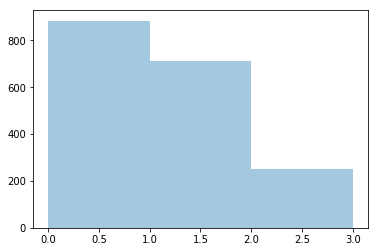

In [18]:
# How consistent are the top 20% commonly changed genes
sns.distplot(sophie_all_counts, bins=np.arange(0, 4), kde=False)

## Pairwise compare different context and platforms

In [12]:
sophie_powers_common = (
    sophie_powers_percentiles[
        sophie_powers_percentiles["percentile (powers)"] >= threshold
    ]
).index
sophie_recount2_common = (
    sophie_recount2_percentiles[
        sophie_recount2_percentiles["percentile (recount2)"] >= threshold
    ]
).index
sophie_crow_common = (
    sophie_crow_percentiles[sophie_crow_percentiles["percentile (crow)"] >= threshold]
).index

In [13]:
print(len(sophie_powers_common))
print(len(sophie_recount2_common))
print(len(sophie_crow_common))

1353
3551
1427


/home/alexandra/anaconda3/envs/generic_expression_new/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


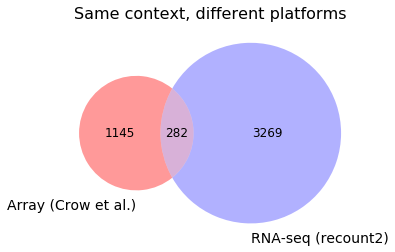

In [14]:
cross_platform_venn = venn2(
    [set(sophie_crow_common), set(sophie_recount2_common)],
    set_labels=("Array (Crow et al.)", "RNA-seq (recount2)"),
)

cross_platform_venn.get_patch_by_id("11").set_color("purple")
cross_platform_venn.get_patch_by_id("11").set_edgecolor("none")
cross_platform_venn.get_patch_by_id("11").set_alpha(0.3)
cross_platform_venn.get_patch_by_id("01").set_color("blue")
cross_platform_venn.get_patch_by_id("01").set_edgecolor("none")
cross_platform_venn.get_patch_by_id("01").set_alpha(0.3)

plt.title("Same context, different platforms", fontsize=16, fontname="Verdana")
for text in cross_platform_venn.set_labels:
    text.set_fontsize(14)
    text.set_fontname("Verdana")

for text in cross_platform_venn.subset_labels:
    text.set_fontsize(12)
    text.set_fontname("Verdana")

# Save figure
matplotlib.pyplot.savefig(
    "cross_platform_venn.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

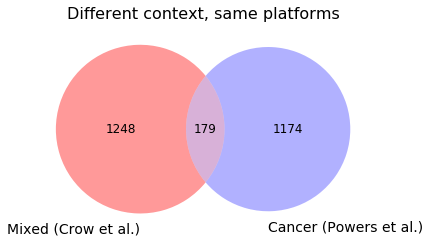

In [15]:
cross_context_venn = venn2(
    [set(sophie_crow_common), set(sophie_powers_common)],
    set_labels=("Mixed (Crow et al.)", "Cancer (Powers et al.)"),
)

cross_context_venn.get_patch_by_id("11").set_color("purple")
cross_context_venn.get_patch_by_id("11").set_edgecolor("none")
cross_context_venn.get_patch_by_id("11").set_alpha(0.3)
cross_context_venn.get_patch_by_id("01").set_color("blue")
cross_context_venn.get_patch_by_id("01").set_edgecolor("none")
cross_context_venn.get_patch_by_id("01").set_alpha(0.3)

plt.title("Different context, same platforms", fontsize=16, fontname="Verdana")

for text in cross_context_venn.set_labels:
    text.set_fontsize(14)
    text.set_fontname("Verdana")

for text in cross_context_venn.subset_labels:
    text.set_fontsize(12)
    text.set_fontname("Verdana")

# Save figure
matplotlib.pyplot.savefig(
    "cross_context_venn.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

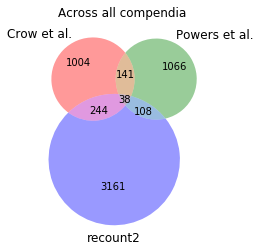

In [16]:
cross_context_venn = venn3(
    [set(sophie_crow_common), set(sophie_powers_common), set(sophie_recount2_common)],
    set_labels=("Crow et al.", "Powers et al.", "recount2"),
)

"""cross_context_venn.get_patch_by_id("11").set_color("purple")
cross_context_venn.get_patch_by_id("11").set_edgecolor("none")
cross_context_venn.get_patch_by_id("11").set_alpha(0.3)
cross_context_venn.get_patch_by_id("01").set_color("blue")
cross_context_venn.get_patch_by_id("01").set_edgecolor("none")
cross_context_venn.get_patch_by_id("01").set_alpha(0.3)"""

plt.title("Across all compendia")

# Save figure
matplotlib.pyplot.savefig(
    "cross_all_venn.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

It looks like the majority of the top 20% commonly changed genes are not consistent across all compendia, but there are some genes that are consistent across platform and context (consistent across 2 compendia but not all 3)

We explored the difference in genes found to be commonly changed in RNA-seq only [here](../explore_RNAseq_only_generic_genes), but more work need to be done here.